### Import

In [1]:
# Import Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from itertools import cycle
import geopandas as gpd
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display
from scipy import stats

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, add_hasia_labels
from ar_funcs import preprocess_ar_area_subregions


In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


### Data

#### AR Time Series

In [3]:
# choose season
ssn = 'djfmam'
ceofid = 'HUV500'
neofs = 2 # choose number of eofs
nk = 3 # choose number of clusters

out_path = path_to_out + ceofid + '/' + ssn + '/' + 'neof' + str(neofs) + '/k' + str(nk) + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'+ 'neof' + str(neofs) + '/k' + str(nk) + '/'

In [4]:
filepath = out_path + 'AR-types_ALLDAYS.csv'
df1 = pd.read_csv(filepath)
df1 = df1.rename(columns={'Unnamed: 0': 'date'})
df1 = df1.set_index(pd.to_datetime(df1['date']))
df1 = df1.drop(columns=['date'])
idx = (df1['AR_CAT'] > 0)
df1 = df1.loc[idx]

df1.index = df1.index.strftime("%Y-%m-%d")
times_lst = df1.index.tolist()
# times_lst
df1

,AR_CAT
date,
1979-12-01,3
1979-12-02,3
1980-01-24,3
1980-02-12,2
1980-02-13,1
...,...
2019-04-09,2
2019-04-15,2
2019-04-16,1


In [5]:
len(times_lst)

759

#### Global Landslide Catalog

In [6]:
fname = path_to_data + 'CH2_generated_data/Global_Landslide_Catalog_Export.csv'
df2 = pd.read_csv(fname)

# Select lat/lon grid
lonmin = 65
lonmax = 100
latmin = 20
latmax = 42

## Select Landslides within Southern Asia region
idx = (df2.latitude >= latmin) & (df2.latitude <= latmax) & (df2.longitude >= lonmin) & (df2.longitude <= lonmax)
df2 = df2.loc[idx]
df2

,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude
3,Reuters,https://in.reuters.com/article/idINIndia-41450...,1067,07/31/2009 12:00:00 AM,NaN,Dailekh district,"One person was killed in Dailekh district, pol...",Dailekh district,unknown,landslide,...,NP,Mid Western,20908.0,Dailekh,0.75395,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,81.708000,28.837800
32,One India,https://www.oneindia.com/2009/07/23/darjeeling...,1055,07/22/2009 12:00:00 AM,NaN,"Kerseong, West Bengal",The disruption of popular toy train services i...,"Kerseong, West Bengal",10km,landslide,...,IN,Bengal,46427.0,Kārsiyāng,0.15035,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,88.278800,26.882600
34,One India,https://www.oneindia.com/2009/07/23/darjeeling...,1054,07/22/2009 12:00:00 AM,NaN,"Gayabari, West Bengal",The disruption of popular toy train services i...,"Gayabari, West Bengal",10km,landslide,...,IN,Bengal,46427.0,Kārsiyāng,4.62496,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,88.314300,26.857200
39,SAARC Disaster Management Centre,http://saarc-sdmc.nic.in/latest192.asp,1048,07/02/2009 03:00:00 AM,NaN,"Deurali VDC-8 in Kaski district,",At least six people have died and two more hav...,"Deurali VDC-8 in Kaski district,",50km,landslide,...,NP,Western Region,200000.0,Pokhara,7.08117,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,83.980600,28.203900
40,SAARC Disaster Management Centre,http://saarc-sdmc.nic.in/latest192.asp,1049,07/02/2009 12:00:00 AM,NaN,"Dhapade VDC-5, Tanahun district",At least six people have died and two more hav...,"Dhapade VDC-5, Tanahun district",25km,landslide,...,NP,Western Region,0.0,Lamjung,32.28507,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,84.227900,27.944700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11019,AKI Press,http://akipress.com/news:591338/,10897,04/17/2017 04:00:00 AM,NaN,Landslide in Chyrmash,Landslide hits 3 houses,"Chyrmash (??), Ozgon, Osh, Kyrgyzstan",50km,landslide,...,NaN,NaN,NaN,NaN,NaN,07/28/2017 01:34:00 PM,12/07/2017 09:19:00 PM,02/15/2018 03:51:00 PM,73.604732,40.804379
11022,Daily World,https://dailyworld.in/nagaon-a-landslide-at-na...,11162,07/09/2017 06:45:00 PM,NaN,Landslide blocks NH-37,Following continuous rain. Article: landslide ...,"Burapahar, Nagaon, Assam",5km,landslide,...,NaN,NaN,NaN,NaN,NaN,07/10/2017 06:45:00 PM,12/20/2017 03:53:00 PM,02/15/2018 03:51:00 PM,93.131951,26.566362
11029,Greater Kashmir,http://www.greaterkashmir.com/news/jammu/lands...,10845,03/25/2017 05:32:00 PM,NaN,Barnari Sigdi Landslide,Two teenage girls died after they were buried ...,"Barnari Sigdi area, Tehsil Mughalmaidan, Kisht...",5km,landslide,...,NaN,NaN,NaN,NaN,NaN,09/21/2017 05:32:00 PM,12/05/2017 06:45:00 PM,02/15/2018 03:51:00 PM,75.680611,33.403080
11030,NBC Daily,http://www.nbcdaily.com/separate-landslides-ki...,10973,12/15/2016 05:00:00 AM,NaN,Landslide at Pub Sarania Hill,An octogenarian was killed when a sudden lands...,"Pub Sarania Hill, Guwahati, Assam, India",1km,landslide,...,NaN,NaN,NaN,NaN,NaN,07/26/2017 01:22:00 PM,12/08/2017 08:37:00 PM,02/15/2018 03:51:00 PM,91.772042,26.181606


In [7]:
df2_copy = df2.set_index(pd.to_datetime(df2.event_date))

# Subset only days HMA = True
x = times_lst
y = df2_copy.index

df = df2_copy.loc[y.isin(x)]
df

,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude
event_date,,,,,,,,,,,,,,,,,,,,,
2007-03-19,Tribune India.com,NaN,37,03/19/2007 12:00:00 AM,NaN,Doba,"2 killed, 5 injured",Doba,25km,landslide,...,IN,Kashmir,14711.0,Kupwāra,18.10887,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,74.333300,33.877800
2014-02-28,eKantipur.com,http://www.ekantipur.com/2014/02/28/national/b...,5909,02/28/2014 12:00:00 AM,NaN,Mahakali Hwy 10200,Thirty-five families have been displaced by a ...,Mahakali Hwy 10200,5km,landslide,...,NP,Western Region,18317.0,Dārchulā,32.01850,08/24/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,80.670000,29.580000
2011-02-13,Daily News and Analysis,http://www.dnaindia.com/india/report_j-and-k-h...,3116,02/13/2011 12:00:00 AM,NaN,"Srinagar-Jammu Natl. Hwy., at Panthal, Srinaga...","Jammu-Srinagar National Highway, connecting Ka...","Srinagar-Jammu Natl. Hwy., at Panthal, Srinaga...",25km,landslide,...,IN,Kashmir,3278.0,Banihāl,5.78589,09/15/2014 05:13:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.192106,33.338760
2011-03-19,pakistantimes,http://www.pakistantimes.net/pt/detail.php?new...,3250,03/19/2011 12:00:00 AM,NaN,"Jammu-Srinagar hwy, Digdol, Ramban, Jammu and ...",The landslides blocked the road on at least fo...,"Jammu-Srinagar hwy, Digdol, Ramban, Jammu and ...",5km,landslide,...,IN,Kashmir,3278.0,Banihāl,9.75302,09/10/2014 07:58:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.177300,33.330800
2015-03-31,Indian Express,http://indianexpress.com/article/india/india-o...,6928,03/31/2015 12:00:00 AM,NaN,Joshimath-Mallari road,Four persons were killed after a landslide hit...,Joshimath-Mallari road,25km,landslide,...,IN,Uttarakhand,13865.0,Joshīmath,24.26124,05/26/2015 10:07:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,79.810200,30.614500
2011-02-07,tribune.com,http://tribune.com.pk/story/127349/rain-snow-d...,3099,02/07/2011 12:00:00 AM,NaN,"road between Muzaffarabad and Chakothi, Neelum...",MUZAFFARABAD: Heavy rain and snow have disru...,"road between Muzaffarabad and Chakothi, Neelum...",25km,landslide,...,PK,Azad Kashmir,725000.0,Muzaffarābād,24.55782,09/10/2014 08:15:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,73.673000,34.225600
2016-04-19,Assam Tribune,http://www.assamtribune.com/scripts/detailsnew...,9405,04/19/2016 12:00:00 AM,NaN,"Techahan Ward, Mon, Nagaland, India",(Landslide may have occurred within a week of ...,"Techahan Ward, Mon, Nagaland, India",1km,landslide,...,IN,Nagaland,18742.0,Mon,3.71285,08/03/2016 08:40:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,95.024300,26.722300
2010-04-01,en.apa,http://en.apa.az/news.php?id=119178,1611,04/01/2010 12:00:00 AM,NaN,"Paglanala village, Dholai Block, near Dwarband...",The latest disaster has come from Assam where ...,"Paglanala village, Dholai Block, near Dwarband...",25km,landslide,...,IN,Assam,39982.0,Hāflong,1.49521,09/12/2014 02:02:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,93.028000,25.155300
2014-04-03,Dawn,http://www.dawn.com/news/1249885/eight-killed-...,9374,04/03/2014 12:00:00 AM,NaN,Samgam area of Azad Kashmir,The valley’s Deputy Commissioner Abdul Hameed ...,Samgam area of Azad Kashmir,50km,landslide,...,PK,Azad Kashmir,725000.0,Muzaffarābād,1.42424,08/03/2016 05:09:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,74.213462,34.803163


In [8]:
# fix up landslide df for merging
df_event = df.drop(columns=['event_date'])
df_event = df_event.reset_index()

# fix up AR Type df for merging
df1_event = df1.reset_index()
df1_event = df1_event.rename(columns={'date': 'event_date'})
df1_event.event_date = df1_event.event_date.astype(df_event.event_date.dtype)
df1_event

# merge AR Type and Landslide event togethers
merged_data = pd.merge(df_event, df1_event, how='outer', on='event_date')
merged_data

,event_date,source_name,source_link,event_id,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude,AR_CAT
0,2007-03-19,Tribune India.com,NaN,37.0,NaN,Doba,"2 killed, 5 injured",Doba,25km,landslide,...,Kashmir,14711.0,Kupwāra,18.10887,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,74.333300,33.87780,2
1,2014-02-28,eKantipur.com,http://www.ekantipur.com/2014/02/28/national/b...,5909.0,NaN,Mahakali Hwy 10200,Thirty-five families have been displaced by a ...,Mahakali Hwy 10200,5km,landslide,...,Western Region,18317.0,Dārchulā,32.01850,08/24/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,80.670000,29.58000,2
2,2011-02-13,Daily News and Analysis,http://www.dnaindia.com/india/report_j-and-k-h...,3116.0,NaN,"Srinagar-Jammu Natl. Hwy., at Panthal, Srinaga...","Jammu-Srinagar National Highway, connecting Ka...","Srinagar-Jammu Natl. Hwy., at Panthal, Srinaga...",25km,landslide,...,Kashmir,3278.0,Banihāl,5.78589,09/15/2014 05:13:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.192106,33.33876,3
3,2011-02-13,dnaindia,http://www.dnaindia.com/india/report_j-and-k-h...,3115.0,NaN,"Srinagar-Jammu Natl. Hwy., at Digdole(Digdol)(...",Fresh snowfall around Jawahar tunnel and lands...,"Srinagar-Jammu Natl. Hwy., at Digdole(Digdol)(...",5km,landslide,...,Kashmir,3278.0,Banihāl,9.75302,09/10/2014 08:01:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.182700,33.30370,3
4,2011-02-13,dnaindia,http://www.dnaindia.com/india/report_j-and-k-h...,3114.0,NaN,"Batote-Doda-Kishtwar road, at Jathi(?) and Dra...",The Batote-Doda-Kishtwar road was also blocked...,"Batote-Doda-Kishtwar road, at Jathi(?) and Dra...",5km,landslide,...,Kashmir,20553.0,Kishtwār,15.28833,09/10/2014 08:12:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.810100,33.18040,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2019-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
777,2019-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
778,2019-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
779,2019-04-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [9]:
idx = (merged_data['event_id'] > 0)
merged_data = merged_data.loc[idx]
merged_data

,event_date,source_name,source_link,event_id,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude,AR_CAT
0,2007-03-19,Tribune India.com,NaN,37.0,NaN,Doba,"2 killed, 5 injured",Doba,25km,landslide,...,Kashmir,14711.0,Kupwāra,18.10887,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,74.333300,33.877800,2
1,2014-02-28,eKantipur.com,http://www.ekantipur.com/2014/02/28/national/b...,5909.0,NaN,Mahakali Hwy 10200,Thirty-five families have been displaced by a ...,Mahakali Hwy 10200,5km,landslide,...,Western Region,18317.0,Dārchulā,32.01850,08/24/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,80.670000,29.580000,2
2,2011-02-13,Daily News and Analysis,http://www.dnaindia.com/india/report_j-and-k-h...,3116.0,NaN,"Srinagar-Jammu Natl. Hwy., at Panthal, Srinaga...","Jammu-Srinagar National Highway, connecting Ka...","Srinagar-Jammu Natl. Hwy., at Panthal, Srinaga...",25km,landslide,...,Kashmir,3278.0,Banihāl,5.78589,09/15/2014 05:13:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.192106,33.338760,3
3,2011-02-13,dnaindia,http://www.dnaindia.com/india/report_j-and-k-h...,3115.0,NaN,"Srinagar-Jammu Natl. Hwy., at Digdole(Digdol)(...",Fresh snowfall around Jawahar tunnel and lands...,"Srinagar-Jammu Natl. Hwy., at Digdole(Digdol)(...",5km,landslide,...,Kashmir,3278.0,Banihāl,9.75302,09/10/2014 08:01:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.182700,33.303700,3
4,2011-02-13,dnaindia,http://www.dnaindia.com/india/report_j-and-k-h...,3114.0,NaN,"Batote-Doda-Kishtwar road, at Jathi(?) and Dra...",The Batote-Doda-Kishtwar road was also blocked...,"Batote-Doda-Kishtwar road, at Jathi(?) and Dra...",5km,landslide,...,Kashmir,20553.0,Kishtwār,15.28833,09/10/2014 08:12:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.810100,33.180400,3
5,2011-03-19,pakistantimes,http://www.pakistantimes.net/pt/detail.php?new...,3250.0,NaN,"Jammu-Srinagar hwy, Digdol, Ramban, Jammu and ...",The landslides blocked the road on at least fo...,"Jammu-Srinagar hwy, Digdol, Ramban, Jammu and ...",5km,landslide,...,Kashmir,3278.0,Banihāl,9.75302,09/10/2014 07:58:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.177300,33.330800,2
6,2011-03-19,Daily News and Analysis,http://www.dnaindia.com/india/report_j-and-k-h...,3251.0,NaN,"Jammu-Srinagar hwy, Panthal, Ramban, Jammu and...","Mar 19, 2011, 18:02 IST he Jammu-Srinagar Na...","Jammu-Srinagar hwy, Panthal, Ramban, Jammu and...",25km,landslide,...,Kashmir,3278.0,Banihāl,5.78589,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.191688,33.339033,2
7,2011-03-19,pakistantimes,http://www.pakistantimes.net/pt/detail.php?new...,3252.0,NaN,"Jammu-Srinagar hwy, Sheeri(?), Ramban, Jammu a...",The landslides blocked the road on at least fo...,"Jammu-Srinagar hwy, Sheeri(?), Ramban, Jammu a...",50km,landslide,...,Kashmir,7317.0,Rāmban,7.32953,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.161100,33.246600,2
8,2015-03-31,Indian Express,http://indianexpress.com/article/india/india-o...,6928.0,NaN,Joshimath-Mallari road,Four persons were killed after a landslide hit...,Joshimath-Mallari road,25km,landslide,...,Uttarakhand,13865.0,Joshīmath,24.26124,05/26/2015 10:07:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,79.810200,30.614500,1
9,2011-02-07,tribune.com,http://tribune.com.pk/story/127349/rain-snow-d...,3099.0,NaN,"road between Muzaffarabad and Chakothi, Neelum...",MUZAFFARABAD: Heavy rain and snow have disru...,"road between Muzaffarabad and Chakothi, Neelum...",25km,landslide,...,Azad Kashmir,725000.0,Muzaffarābād,24.55782,09/10/2014 08:15:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,73.673000,34.225600,3


### Elevation Data

In [10]:
fname = path_to_data + 'elevation_data/ETOPO1_Bed_g_gmt4.grd'
version = 'bedrock'
grid = xr.open_dataset(fname)
# Add more metadata and fix some names
names = {"ice": "Ice Surface", "bedrock": "Bedrock"}
grid = grid.rename(z=version, x="lon", y="lat")
grid[version].attrs["long_name"] = "{} relief".format(names[version])
grid[version].attrs["units"] = "meters"
grid[version].attrs["vertical_datum"] = "sea level"
grid[version].attrs["datum"] = "WGS84"
grid.attrs["title"] = "ETOPO1 {} Relief".format(names[version])
grid.attrs["doi"] = "10.7289/V5C8276M"

# Load sliced variables.
etopo = grid.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))
lats = etopo.lat
lons = etopo.lon
topo = etopo.bedrock

# cmap setup
cmap = cmo.topo
# clipcmap = cmocean.tools.crop_by_percent(cmap, 5, which='both', N=None)
cflevs = np.arange(-6000, 6000, )

### Plot Bubble Map

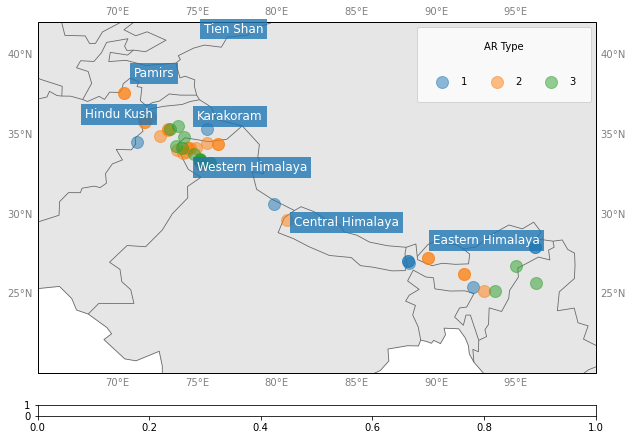

In [11]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+5,5)
dy = np.arange(latmin,latmax+5,5)

# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + 'HMA_AR_landslides.png'
nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.45,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='3%',
                label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy, left_lats=False, right_lats=True)
    
#     # shaded contour
#     cf = ax.contourf(lons, lats, topo, 100, cmap=cmap, 
#                    transform=datacrs,
#                    vmin=-6000, vmax=6000,extend="max")
    
    # Bubbles
    groups = merged_data.groupby('AR_CAT')
    for name, group in groups:
        ax.plot(group.longitude, group.latitude, marker='o', linestyle='', markersize=12,
                 label=name, transform=mapcrs, alpha=0.5)
    

    ax.legend(loc='upper right', labelspacing=2.5, borderpad=1.5, title='AR Type', ncol=3)
    
    # subtitles
#     ax.set_title('Landslides in Southern Asia', loc='left', fontsize=12)
#     add hasia label
    add_hasia_labels(ax=ax, fntsize=12)
    
# # Colorbar (single)
# cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=False)
# cb.set_label('Elevation (m)', fontsize=11)
# cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')
plt.show()

In [14]:
merged_data.sort_values(by=['fatality_count'], ascending=False)

,event_date,source_name,source_link,event_id,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude,AR_CAT
48,2016-04-02,nvs24,http://nvs24.com/news/topstories/Dozens-missin...,9365.0,NaN,Phar Kant Jade Mining,"a huge amount of mining debris collapsed, engu...",Phar Kant Jade Mining,10km,landslide,...,Kachin,90894.0,Myitkyina,114.45467,08/03/2016 04:22:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,96.288700,25.621900,3
24,2016-04-03,Daily Times,http://www.dailytimes.com.pk/national/05-Apr-2...,9377.0,NaN,Khyber Pakhtunkhwa,NaN,Khyber Pakhtunkhwa,50km,landslide,...,Gilgit-Baltistan,0.0,Chilas,29.01135,08/03/2016 05:28:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,73.805600,35.506300,3
23,2016-04-03,The Tribune Pakistan,http://tribune.com.pk/story/1085549/othar-nala...,9442.0,NaN,"Othar Nala, Kohistan, Pakistan",(Estimated location within Kohistan). Villager...,"Othar Nala, Kohistan, Pakistan",50km,landslide,...,Khyber Pakhtunkhwa,0.0,Dasu,3.40211,08/05/2016 03:59:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,73.319700,35.311000,3
42,2009-05-26,headlinesindia,http://www.headlinesindia.com/natural-disaster...,1030.0,NaN,"Darjeeling Sadar, Darjeeling West Bengal","With the recovery of three more bodies, the to...","Darjeeling Sadar, Darjeeling West Bengal",25km,landslide,...,Bengal,123797.0,Dārjiling,0.79891,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,88.265221,27.043571,1
18,2010-04-21,gsi.gov,http://www.portal.gsi.gov.in/portal/page?_page...,1775.0,NaN,Arunachal Pradesh,As per PTI report at least 12 people have died...,Arunachal Pradesh,unknown,landslide,...,Arunāchal Pradesh,14927.0,Tezu,5.14944,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,96.177900,27.896500,1
51,2015-01-04,Dawn,http://www.dawn.com/news/1155032/landslide-kil...,6623.0,NaN,a marble mine in Khanqa Miangan area,"An eyewitness, Ajmal Khan, told Dawn on phone ...",a marble mine in Khanqa Miangan area,50km,rock_fall,...,Federally Administered Tribal Areas,1111.0,Shinpokh,19.61309,01/05/2015 06:48:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,71.256200,34.494300,1
13,2014-04-03,Dawn,http://www.dawn.com/news/1249885/eight-killed-...,9374.0,NaN,Samgam area of Azad Kashmir,The valley’s Deputy Commissioner Abdul Hameed ...,Samgam area of Azad Kashmir,50km,landslide,...,Azad Kashmir,725000.0,Muzaffarābād,1.42424,08/03/2016 05:09:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,74.213462,34.803163,3
41,2009-05-26,headlinesindia,http://www.headlinesindia.com/natural-disaster...,1031.0,NaN,"Kurseong, Darjeeling, West Bengal","With the recovery of three more bodies, the to...","Kurseong, Darjeeling, West Bengal",5km,landslide,...,Bengal,46427.0,Kārsiyāng,0.21657,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,88.279100,26.883600,1
27,2010-02-08,dailytimes,http://www.dailytimes.com.pk/default.asp?page=...,1489.0,NaN,"Shangla area of Bazaarkot, Skardu, Muzafarabad...",At least six people were killed in Shangla are...,"Shangla area of Bazaarkot, Skardu, Muzafarabad...",50km,landslide,...,Khyber Pakhtunkhwa,0.0,Alpūrai,5.91603,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,72.662500,34.873300,2
40,2009-05-26,headlinesindia,http://www.headlinesindia.com/natural-disaster...,1032.0,NaN,"Rangiabong (Jorbungalow), Darjeeling, West Bengal","With the recovery of three more bodies, the to...","Rangiabong (Jorbungalow), Darjeeling, West Bengal",5km,landslide,...,Bengal,123797.0,Dārjiling,2.74280,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,88.259200,27.009500,1
